In [1]:
import os
import joblib

import numpy as np
import pandas as pd
from datetime import datetime
import ydata_profiling as yp

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import mlflow
from implicit.als import AlternatingLeastSquares
import psycopg2 as psycopg

import pickle

from catboost import CatBoostClassifier, Pool
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

from dotenv import load_dotenv
import boto3

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Настройка
%matplotlib inline

# Директория

In [3]:
RANDOM_STATE = 36
# Пути и названия файлов заданы в виде параметров
PATH_DATA = '../data'

PATH_MODELS = '../models'
MODEL_FILE = 'model.pkl'

ASSETS_DIR = '../data/asserts'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'project_final_one'
REGISTRY_MODEL_NAME = "ranking_model"

In [4]:
load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# Знакомство с данными

## Категория (category)

In [5]:
# Загрузим датафрейм с категорией
category_tree = pd.read_csv(f'{PATH_DATA}/category_tree.csv')

In [6]:
# Поглядим первые 5 строк
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [7]:
# Проверим типы данных
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [8]:
# Посмотрим пустые значения
category_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

In [9]:
# Отсуствие родительской категории:
category_tree[category_tree.parentid.isnull() == True]

,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


In [10]:
# Проверим дубликаты
category_tree[category_tree.duplicated()]

,categoryid,parentid


In [11]:
# Посмотрим сгруппированный вариант данных
category_tree.groupby('parentid')['categoryid'].count().reset_index().sort_values('categoryid')

,parentid,categoryid
352,1671.0,1
349,1661.0,1
37,157.0,1
291,1394.0,1
294,1401.0,1
...,...,...
264,1259.0,18
77,351.0,19
215,1009.0,22
79,362.0,22


In [12]:
# Воспользуемся ydata_profiling для отображения возможных проблем
yp.ProfileReport(category_tree)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 135.39it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет содержит два столбца, в которых есть ID категории товара (categoryid) и ID родительской категории (parentid). Отмечу, что в родительском ID обнаружены пропуски.

## События (events)

In [13]:
# Загружаем события
events = pd.read_csv(f'{PATH_DATA}/events.csv')

In [14]:
# Смотим первые 5 строк
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [15]:
# Проверяем типы данных
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [16]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [17]:
# Проверим дубликаты
events[events.duplicated()]

,timestamp,visitorid,event,itemid,transactionid
22404,1433180781440,1045411,addtocart,379647,NaN
34465,1433274223925,366538,addtocart,252068,NaN
39738,1433265100661,198153,addtocart,48715,NaN
41774,1433270868154,1268755,view,60980,NaN
42469,1433277134682,555487,addtocart,397642,NaN
...,...,...,...,...,...
2748964,1438346018813,722488,view,97303,NaN
2750464,1438370523152,896869,addtocart,85004,NaN
2752725,1438405570135,708442,addtocart,392883,NaN
2753763,1438376127329,372829,addtocart,388276,NaN


In [18]:
# Уберем дубликаты, так как я не вижу причин их оставлять
events = events.drop_duplicates()

In [19]:
# Посмотрим на типы событий для пропущенных 
events[events['transactionid'].isna()]['event'].unique()

array(['view', 'addtocart'], dtype=object)

In [20]:
# Проверим пропуски
events[events.isna().any(axis=1)]

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


Очевидно, что в данном датафрейме отображается действие клиента, который может просмотраитваь товар и добавлять его в корзину, а если поле transactionid не пустое - то совершить покупку.

In [21]:
# Посмотрим, количество уникальных товаров 
events['itemid'].nunique()

235061

In [22]:
# Количество уникальных визитов/клиентов
events.visitorid.nunique()

1407580

In [23]:
# Доля транзакции к визитам
events['transactionid'].nunique()/events['visitorid'].nunique()

0.012554881427698603

In [24]:
# Доля добавления товара в корзину к визитам
events[events['event']=='addtocart']['visitorid'].nunique()/events['visitorid'].nunique()

0.026799187257562626

Доля добавления в корзину выше в 2 раза, нежели покупка. Народ не переходит к процессу покупки в каждом втором случае.

In [25]:
# Отсортируем данных и посмотрим как проходит формат заказа
events[events['visitorid']==121688].sort_values(by=['itemid', 'timestamp'])

,timestamp,visitorid,event,itemid,transactionid
19145,1433190860050,121688,addtocart,12836,NaN
16292,1433193499698,121688,transaction,12836,11117.0
7392,1433191011831,121688,addtocart,15335,NaN
304,1433193500981,121688,transaction,15335,11117.0
16145,1433191873968,121688,view,25353,NaN
16379,1433191879099,121688,addtocart,25353,NaN
16299,1433193499776,121688,transaction,25353,11117.0
4274,1433191698121,121688,addtocart,80582,NaN
4210,1433191710812,121688,view,80582,NaN
20087,1433193499838,121688,transaction,80582,11117.0


Вижу, что на одну и туже транзакции приходится разное время для каждой позиции. Несовсем понятно, как это возможно, если клиент добавляет товары в корзину и должен (теоретичесски) оплатить все разом. Видимо, это связанно с тем, что событие прудсматривает только два действия, без покупки. 

In [26]:
# Воспользуемся ydata_profiling для отображения возможных проблем
yp.ProfileReport(events[['timestamp', 'visitorid', 'itemid', 'transactionid']])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Позиции (items)

In [27]:
item_1 = pd.read_csv(f'{PATH_DATA}/item_properties_part1.csv')

In [28]:
# Посмотрим на первые 5 строк
item_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [29]:
# Проверим на типы данных
item_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [30]:
# Проверим дубликаты
item_1[item_1.duplicated()]

,timestamp,itemid,property,value


In [31]:
# Проверим пропуски
item_1[item_1.isna().any(axis=1)]

,timestamp,itemid,property,value


In [32]:
# Количество уникальных id позиций
item_1.itemid.nunique()

417053

In [33]:
# Возьмем одну позицию и поглядим что по ней есть:
item_1[item_1['itemid']==355908].sort_values(by=['property', 'timestamp'])

,timestamp,itemid,property,value
3461176,1433646000000,355908,1036,726612
6653206,1433646000000,355908,1066,n1020.000 424566
3628278,1431226800000,355908,112,679677
85902,1431831600000,355908,159,519769
7353433,1435460400000,355908,202,264157
4012974,1433646000000,355908,364,610075
7227008,1432436400000,355908,400,n600.000 424566
6233088,1433041200000,355908,400,n600.000 424566
6431872,1433646000000,355908,400,n600.000 424566
6630656,1434250800000,355908,400,n552.000 639502 n720.000 424566


In [34]:
# Загрузим вторую часть данных
item_2 = pd.read_csv(f'{PATH_DATA}/item_properties_part2.csv')

In [35]:
# Посмотрим на первые 5 строк
item_2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [36]:
# Проверим на типы данных
item_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [37]:
# Проверим дубликаты
item_2[item_2.duplicated()]

,timestamp,itemid,property,value


In [38]:
# Проверим пропуски
item_2[item_2.isna().any(axis=1)]

,timestamp,itemid,property,value


In [39]:
# Количество уникальных id позиций
item_2.itemid.nunique()

417053

In [40]:
# Возьмем одну позицию и поглядим что по ней есть:
item_2[item_2['itemid']==355908].sort_values(by=['property', 'timestamp'])

,timestamp,itemid,property,value
3946532,1431226800000,355908,227,283006 812080
4241224,1432436400000,355908,230,816598 43939
905090,1431226800000,355908,283,812080 362953 537471 264157
2645102,1439089200000,355908,591,1116693
5036592,1432436400000,355908,6,283006 812080
9133650,1439694000000,355908,617,362953
8059762,1439694000000,355908,728,813694
1065655,1435460400000,355908,776,562336
531525,1433041200000,355908,790,n89280.000
133959,1439089200000,355908,790,n97080.000


Данные в датафрейме item_properties содержат информацию о товарах. Типы представлены как в числовых, так и в текстовых форматах: timestamp - временная метка добавления свойства, itemid - идентификатор товара, property - свойство товара, value - значение свойства. В таблицах отсуствуют пропущенных значений и дубли. Столбцы property и value содержат числовые и текстовые значения. К саожалению, свойства товара имеют ID и нам не представялется возможным понять, что из них, скажем, цена, а что цвет и чем лучше оперировать при рекомендации.

## Выводы


Итого, на входе получено три датафрейма: 
- categor_tree - с категорий товаров и их родительской группы; 
- events - с данными о взаимодействий пользователе с товарами; 
- items_property - с данными о товарах и их свойствах.

Из знакомства выделим с данными можно выделить следующее:
 - Таблица category_tree содержит пропуски в столбце parentid;
 - Таблица events содержит дубликаты и пропуски. В столбце event значение addtocard преобразуем в таргет (добавление товара в корзину);
 - Таблица в двух частях item_properties - это датафрейм со свойствами товаров. Две части таблицы будут объединены. 
 
 Для построения рекомендательной системы, необходимо выделить target, добавить информацию по свойствам товара и преобразовать данные в необхоидмый вид.

# Предварительная обработка данных

In [41]:
# Добавим в качестве таргета признак - добавления товара в корзину
events['target'] = events['event'].apply(lambda x: 1 if x=='addtocart' else 0)

In [42]:
# Преобразуем формат времени
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

In [43]:
# Переименуем столбцы
events = events.rename(columns={'visitorid': 'user_id',
                                'itemid': 'item_id'})

In [44]:
# Заполним отсутствие покупок - нулем
events['transactionid'] = events['transactionid'].fillna(0).astype('int')

In [45]:
# Создадим новый признак - факт покупки
events['istransaction'] = events['transactionid'].apply(lambda x: 0 if x==0 else 1).astype('int')

In [46]:
# Посмотрим, что получилось
events.head()

,timestamp,user_id,event,item_id,transactionid,target,istransaction
0,2015-06-02 05:02,257597,view,355908,0,0,0
1,2015-06-02 05:50,992329,view,248676,0,0,0
2,2015-06-02 05:13,111016,view,318965,0,0,0
3,2015-06-02 05:12,483717,view,253185,0,0,0
4,2015-06-02 05:02,951259,view,367447,0,0,0


In [47]:
# Сохраним обновленный датасет
events.to_csv(f'{PATH_DATA}/events_new.csv', index=False)

In [48]:
# Объединим две части таблицы
items = pd.concat([item_1, item_2], axis=0)

In [49]:
# Преобразуем дату
items['timestamp'] = pd.to_datetime(items['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

In [50]:
# Посмотрим, что получилось
items.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00,460429,categoryid,1338
1,2015-09-06 03:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00,59481,790,n15360.000
4,2015-05-17 03:00,156781,917,828513


Предполагаю, что необходимо брать последние изменения товаров и не смотреть на timestamp, в любом случае, для рекомендательной системы добавления описания товара - мало чем поможет.

In [51]:
# Остортируем датасет по времени и товарам
items = items.sort_values(['timestamp', 'itemid']).reset_index(drop=True)

In [52]:
# Посмотрим на результат
items.head()

,timestamp,itemid,property,value
0,2015-05-10 03:00,0,283,66094 372274 478989
1,2015-05-10 03:00,0,6,1152934 1238769
2,2015-05-10 03:00,0,159,519769
3,2015-05-10 03:00,0,678,372274
4,2015-05-10 03:00,0,790,n91200.000


In [53]:
# Удалим дубликаты, оставив только "свежую" строку со свойствами
items = items.drop_duplicates(['itemid','property','value'], keep='last').reset_index(drop=True)

In [54]:
# Посмотрим на результат
items.head(15)

,timestamp,itemid,property,value
0,2015-05-10 03:00,0,283,66094 372274 478989
1,2015-05-10 03:00,0,159,519769
2,2015-05-10 03:00,0,678,372274
3,2015-05-10 03:00,0,790,n91200.000
4,2015-05-10 03:00,0,categoryid,209
5,2015-05-10 03:00,1,available,1
6,2015-05-10 03:00,1,776,379040
7,2015-05-10 03:00,1,categoryid,1114
8,2015-05-10 03:00,1,112,679677
9,2015-05-10 03:00,1,159,519769


In [55]:
# Переименуем столбец в привычный
items = items.rename(columns={'itemid': 'item_id'})

In [56]:
# Сохраним полученный датасет
items.to_csv(f'{PATH_DATA}/items_new.csv', index=False)

# EDA

In [57]:
# Загружаем события
items = pd.read_csv(f'{PATH_DATA}/items_new.csv')
events = pd.read_csv(f'{PATH_DATA}/events_new.csv')

In [58]:
# Посмотрим, за какой период у нас есть данные
print("Дата первая: {}".format(events.timestamp.min()))
print("Дата последняя: {}".format(events.timestamp.max()))

Дата первая: 2015-05-03 03:00
Дата последняя: 2015-09-18 02:59


Так как у нас данные с мая по сентябрь 2015 года, то, скорее всего, имеет смысл посмотреть распределение по месяцам и дням

In [59]:
# Преобразуем формат данных
events['timestamp'] = pd.to_datetime(events['timestamp'])

# Извлекаем день недели и час
events['month'] = events['timestamp'].dt.month
events['day_id'] = events['timestamp'].dt.date
events['day_of_week'] = events['timestamp'].dt.dayofweek
events['day'] = events['timestamp'].dt.day 
events['hour'] = events['timestamp'].dt.hour

In [60]:
# Агрегирцуем данные до месяца с учетом пользователей и событий
events_month = events.groupby("month").agg(events=("month", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

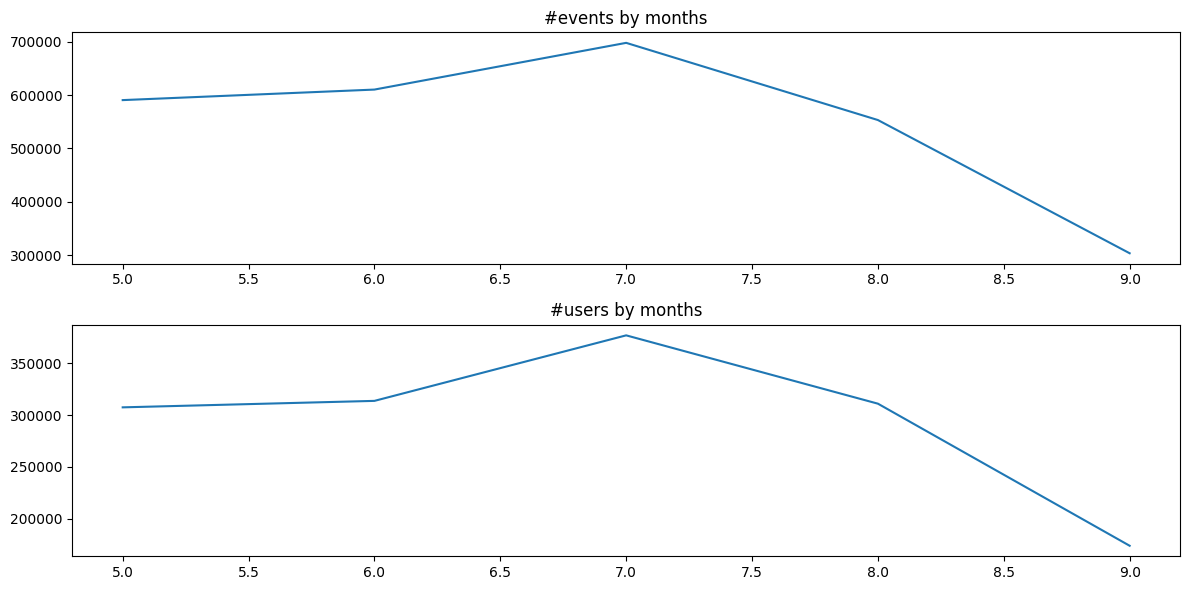

In [61]:
# распределение по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_month["month"], events_month["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_month["month"], events_month["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

In [62]:
# Агрегирцуем данные до даты с учетом пользователей и событий
events_day_id = events.groupby("day_id").agg(events=("day_id", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

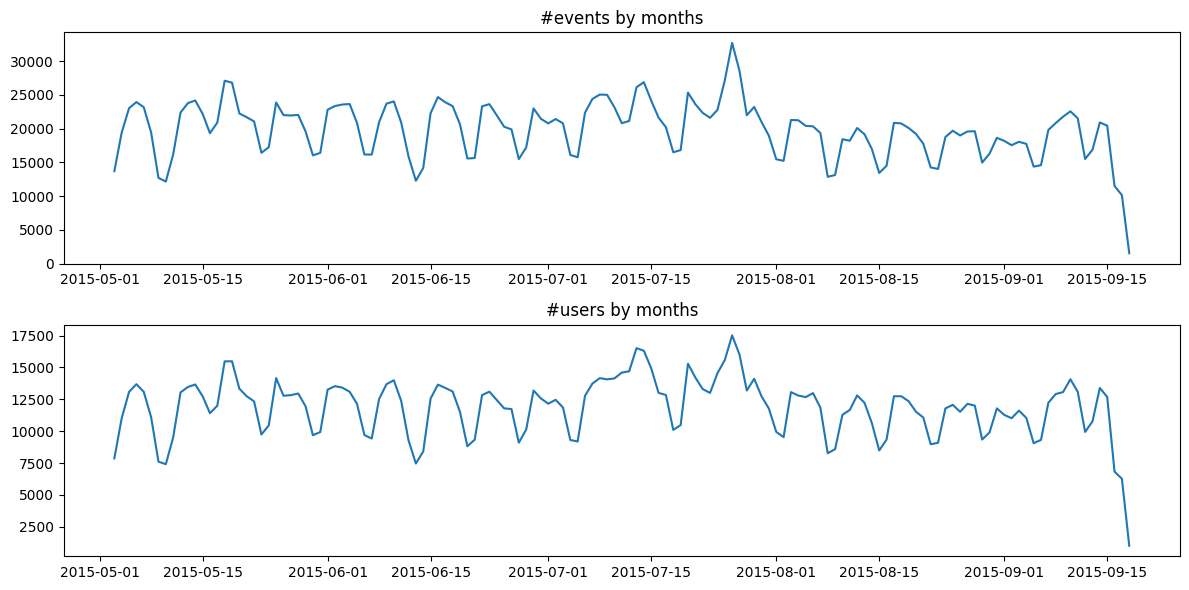

In [63]:
# распределение по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day_id["day_id"], events_day_id["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_day_id["day_id"], events_day_id["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

In [64]:
# Агрегирцуем данные до дня с учетом пользователей и событий
events_day = events.groupby("day").agg(events=("day", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

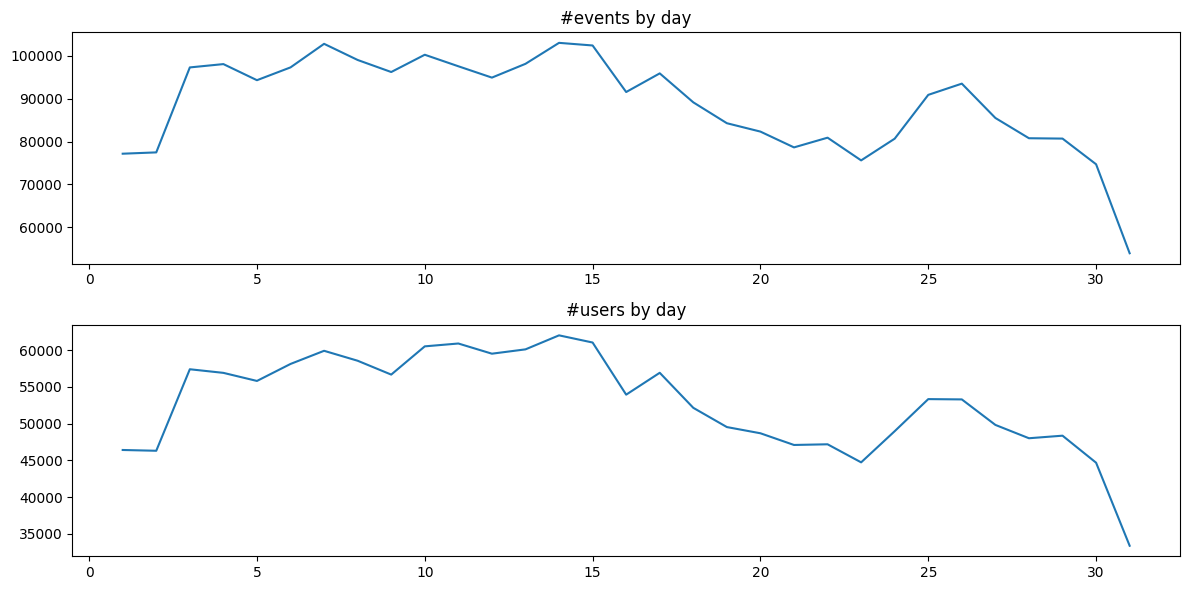

In [65]:
# распределение по дням

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day["day"], events_day["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by day")

ax = axs[1]
ax.plot(events_day["day"], events_day["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by day")

fig.tight_layout()

In [66]:
# Агрегирцуем данные до дня недели с учетом пользователей и событий
events_day_of_week = events.groupby("day_of_week").agg(events=("day_of_week", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

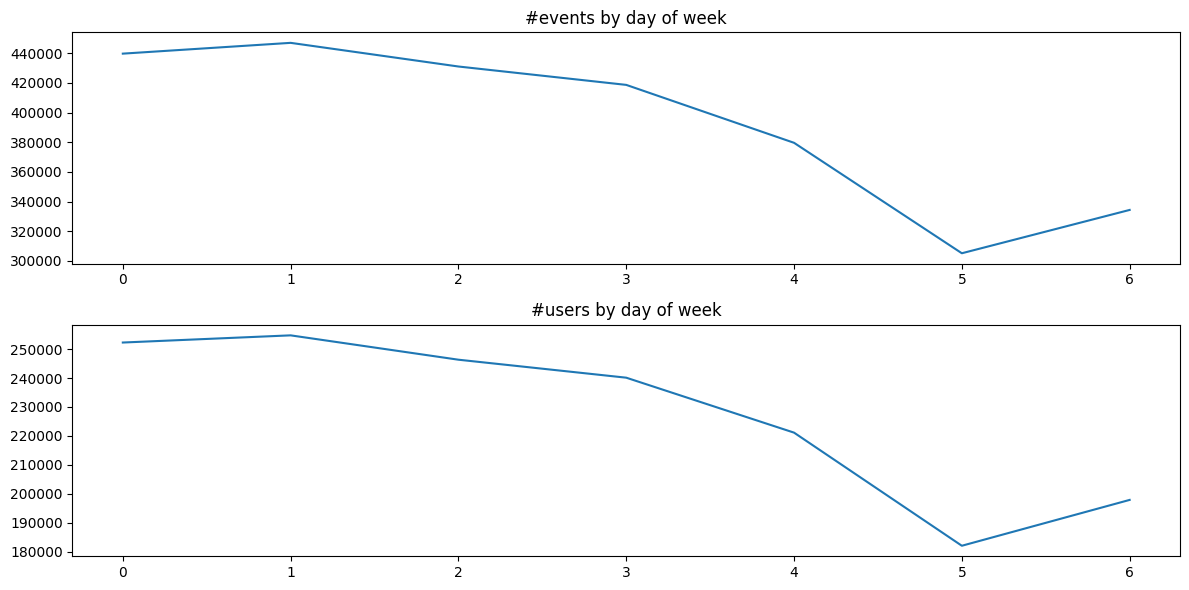

In [67]:
# распределение по дням недели (0 - Пн, 6 - Вс)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day_of_week["day_of_week"], events_day_of_week["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by day of week")

ax = axs[1]
ax.plot(events_day_of_week["day_of_week"], events_day_of_week["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by day of week")

fig.tight_layout()

In [68]:
# Агрегирцуем данные до часа с учетом пользователей и событий
events_hour = events.groupby("hour").agg(events=("hour", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

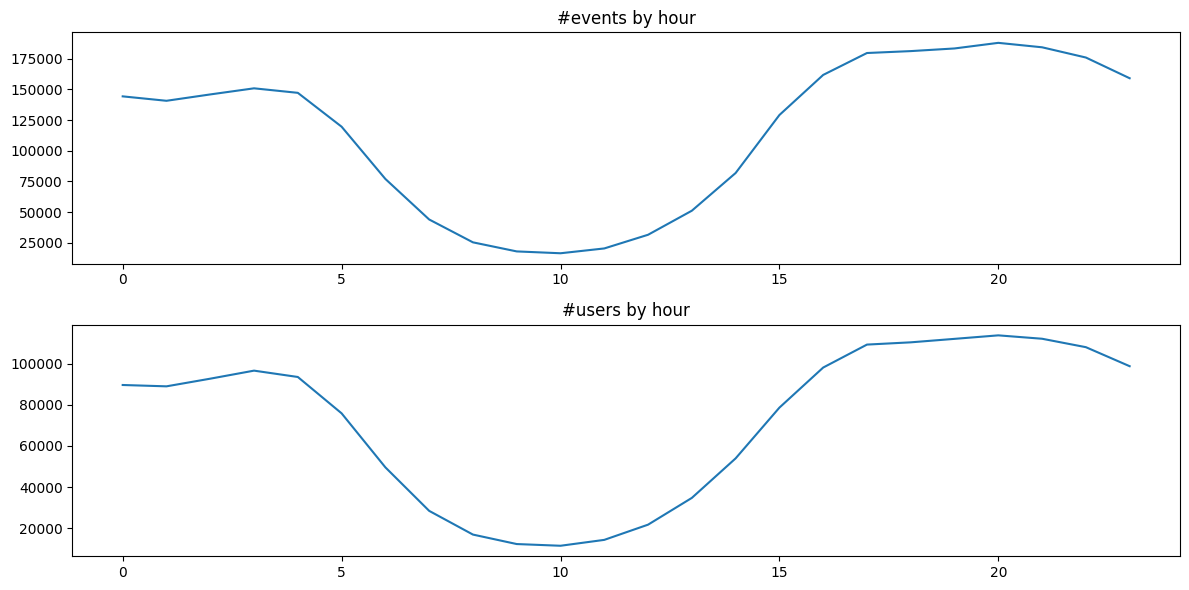

In [69]:
# распределение по часам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_hour["hour"], events_hour["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by hour")

ax = axs[1]
ax.plot(events_hour["hour"], events_hour["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by hour")

fig.tight_layout()

In [70]:
# Посмотрим на распределение таргета
print(events['target'].value_counts(normalize=True))

target
0    0.974973
1    0.025027
Name: proportion, dtype: float64


In [71]:
# Среднее количество взаимодействий по юзерам за весь период
round(events.groupby('user_id').size().mean(), 4)

1.9577

In [72]:
# Среднее количество целевых действий по юзерам за весь период
round(events[events['target']==1].groupby('user_id').size().mean(), 4)

1.8283

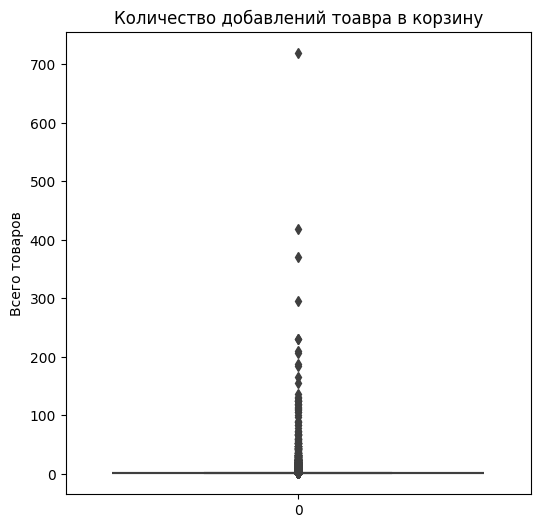

In [73]:
# Подсчет суммарного количества прослушанных треков
target_boxplot = (
    events[events['target'] == 1]
    .groupby('user_id')
    .agg(item_count=('item_id', 'count'))
    .reset_index(drop=True)
)

# Создание графика
plt.figure(figsize=(6, 6))
sns.boxplot(data=target_boxplot['item_count'])

# Настройка заголовка и осей
plt.title('Количество добавлений тоавра в корзину')
plt.ylabel('Всего товаров')

plt.show()

In [74]:
# Посмотрим на распределение по квантилям
target_boxplot.describe()

,item_count
count,37722.000000
mean,1.828270
std,6.872151
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,719.000000


In [75]:
events

,timestamp,user_id,event,item_id,transactionid,target,istransaction,month,day_id,day_of_week,day,hour
0,2015-06-02 05:02:00,257597,view,355908,0,0,0,6,2015-06-02,1,2,5
1,2015-06-02 05:50:00,992329,view,248676,0,0,0,6,2015-06-02,1,2,5
2,2015-06-02 05:13:00,111016,view,318965,0,0,0,6,2015-06-02,1,2,5
3,2015-06-02 05:12:00,483717,view,253185,0,0,0,6,2015-06-02,1,2,5
4,2015-06-02 05:02:00,951259,view,367447,0,0,0,6,2015-06-02,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2755636,2015-08-01 03:13:00,591435,view,261427,0,0,0,8,2015-08-01,5,1,3
2755637,2015-08-01 03:30:00,762376,view,115946,0,0,0,8,2015-08-01,5,1,3
2755638,2015-08-01 02:57:00,1251746,view,78144,0,0,0,8,2015-08-01,5,1,2
2755639,2015-08-01 03:08:00,1184451,view,283392,0,0,0,8,2015-08-01,5,1,3


In [76]:
# Посмотрим на поплуряные признаки товаров
items.groupby('property')['item_id'].count().sort_values(ascending=False).head(20)

property
790           758982
888           576145
available     484054
categoryid    442432
283           428643
6             422256
678           420884
364           420568
776           417337
764           417053
159           417053
112           417053
202           416446
917           416235
839           398013
227           329360
698           275717
689           211971
28            170106
928           150838
Name: item_id, dtype: int64

Так как совершенно не понятно, что эти признаки олзначают, попробую построить рекомендацию на ТОП15 из них. Для этого сделаем следующее:

In [77]:
prop = pd.DataFrame(items.groupby('property')['item_id'].count().sort_values(ascending=False).head(15))
prop = prop.reset_index()
prop = prop['property'].to_list()

In [78]:
prop

['790',
 '888',
 'available',
 'categoryid',
 '283',
 '6',
 '678',
 '364',
 '776',
 '764',
 '159',
 '112',
 '202',
 '917',
 '839']

In [79]:
# Проверим разницу между наличием товарам с нашими признаким и их общим количеством
items['item_id'].nunique() - items[items['property'].isin(prop)]['item_id'].nunique()

0

Отлично, значит нормально выбрали.

In [80]:
# Создание списка для хранения новых данных
df = []

# Проходим по каждому элементу из наешго списка
for pr in prop:
    # Фильтруем по свойству
    filtered_items = items[items['property'] == pr].rename(columns={'value': pr}).reset_index(drop=True)
    filtered_items = filtered_items[['item_id', pr]]
    df.append(filtered_items)

# Объединяем все DataFrame в один, оставим последнее по дате изменение
items_top_properties = pd.concat(df, axis=0).groupby('item_id', as_index=False).last()

In [81]:
# Проверим пропуски
items_top_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417053 entries, 0 to 417052
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   item_id     417053 non-null  int64 
 1   790         417053 non-null  object
 2   888         417053 non-null  object
 3   available   417053 non-null  object
 4   categoryid  417053 non-null  object
 5   283         417053 non-null  object
 6   6           409065 non-null  object
 7   678         417019 non-null  object
 8   364         417053 non-null  object
 9   776         407305 non-null  object
 10  764         417053 non-null  object
 11  159         417053 non-null  object
 12  112         417053 non-null  object
 13  202         414217 non-null  object
 14  917         416171 non-null  object
 15  839         396644 non-null  object
dtypes: int64(1), object(15)
memory usage: 50.9+ MB


Остается посмотреть взаимодействие

In [82]:
# Проверим, для всех ли товаров из датасета с взаимодействиями есть свойства товаров
items_list = items_top_properties['item_id'].unique()

print(f"Количество строк с взаимодействиями: {events.shape[0]}")
print(f"Количество строк без описаний товаров: {events[~events['item_id'].isin(items_list)].shape[0]}")
print(f"% строк без описаний товаров: {events[~events['item_id'].isin(items_list)].shape[0]/events.shape[0]*100:.2f}%")

Количество строк с взаимодействиями: 2755641
Количество строк без описаний товаров: 255576
% строк без описаний товаров: 9.27%


In [83]:
# Удалим товары без свойств
events = events[events['item_id'].isin(items_list)].reset_index(drop=True)

In [84]:
# Присоединим признаки
events_prop = events.merge(items_top_properties, on='item_id', how='left')

In [85]:
# Посмотрим на результат
events_prop.head()

,timestamp,user_id,event,item_id,transactionid,target,istransaction,month,day_id,day_of_week,...,6,678,364,776,764,159,112,202,917,839
0,2015-06-02 05:02:00,257597,view,355908,0,0,0,6,2015-06-02,1,...,283006 812080,537471,610075,562336,1285872,519769,679677,264157,264157,537471
1,2015-06-02 05:50:00,992329,view,248676,0,0,0,6,2015-06-02,1,...,140719 1242195,896095,525637,421232,1285872,519769,679677,857982,857982,896095
2,2015-06-02 05:12:00,483717,view,253185,0,0,0,6,2015-06-02,1,...,1055600,1261266,1255955,307837,1285872,519769,679677,754187 n12000.000,537499,1261266
3,2015-06-02 05:02:00,951259,view,367447,0,0,0,6,2015-06-02,1,...,780351,801383,580904,312011,1285872,519769,679677,1079844 1069567,1228225,801383
4,2015-06-02 05:48:00,972639,view,22556,0,0,0,6,2015-06-02,1,...,None,592849,1071732,486896,1285872,519769,679677,n74642124.000 n242124.000,n74642124.000 n242124.000,592849


In [86]:
# Теперь можно присоединить датасет category_tree

# Заполним категорию 0
events_prop['categoryid'] = events_prop['categoryid'].fillna('0')

# Преобразуем тип данных
events_prop['categoryid'] = events_prop['categoryid'].astype('int')

events_prop = events_prop.merge(category_tree, on='categoryid', how='left')

In [87]:
# Подсчет всех user_id с учетом просмотров и покупок
events_prop['rating_count'] = events_prop.groupby('item_id')['user_id'].transform('count')

# Отмасштабируем признак, чтобы оценки были в одной шкале
scaler = MinMaxScaler()

events_prop['rating'] = scaler.fit_transform(events_prop[['rating_count']])

Категаризация по такому количеству признаков может не взлететь, поэтому необходим оставть основные.

In [88]:
# Отберем необходимые признаки
true_columns = ['timestamp',
                    'user_id',
                    'item_id',
                    'available',
                    'categoryid',
                    'parentid',
                    'istransaction',
                    'day_of_week',
                    'day',
                    'hour',
                    'rating',
                    'target']

# Создадим итоговый датасет
events_df = events_prop[true_columns]

In [89]:
# Посмотрим на итоговый датафрейм
events_df.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
0,2015-06-02 05:02:00,257597,355908,1,1173,805.0,0,1,2,5,0.016417,0
1,2015-06-02 05:50:00,992329,248676,1,1231,901.0,0,1,2,5,0.009675,0
2,2015-06-02 05:12:00,483717,253185,0,914,226.0,0,1,2,5,0.003811,0
3,2015-06-02 05:02:00,951259,367447,0,491,679.0,0,1,2,5,0.075931,0
4,2015-06-02 05:48:00,972639,22556,0,1074,339.0,0,1,2,5,0.000586,0


In [90]:
# Выведем топ-20 товаров по рейтингу
events_df.drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(20)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
68291,2015-06-04 21:32:00,244230,187946,0,1393,1383.0,0,3,4,21,1.000000,0
5163,2015-06-01 17:23:00,1026179,461686,1,1037,402.0,0,0,1,17,0.871885,0
3096,2015-06-02 03:41:00,615875,5411,1,789,14.0,0,1,2,3,0.683964,0
1280,2015-06-01 13:07:00,1260217,370653,0,82,1125.0,0,0,1,13,0.543242,0
3413,2015-06-01 19:41:00,71037,219512,1,5,1637.0,0,0,1,19,0.527411,0
260,2015-06-01 21:22:00,463621,257040,0,683,1606.0,0,0,1,21,0.482556,0
1470,2015-06-01 17:24:00,24919,298009,0,529,623.0,0,0,1,17,0.481091,0
247,2015-06-01 20:58:00,945697,96924,0,56,1497.0,0,0,1,20,0.478452,0
2216,2015-06-01 20:33:00,645651,309778,0,683,1606.0,0,0,1,20,0.476986,0
7221,2015-06-01 19:44:00,1135594,384302,1,5,1637.0,0,0,1,19,0.471123,0


In [91]:
# Выведем топ по рейтингу среди купленных товаров
events_df[events_df['target']==1].drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(20)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
551428,2015-06-30 19:06:00,755375,187946,0,1393,1383.0,0,1,30,19,1.000000,1
57099,2015-06-04 04:26:00,1259098,461686,1,1037,402.0,0,3,4,4,0.871885,1
164302,2015-06-09 19:52:00,72742,5411,1,789,14.0,0,1,9,19,0.683964,1
377782,2015-06-22 05:27:00,289539,219512,1,5,1637.0,0,0,22,5,0.527411,1
86383,2015-06-05 21:07:00,390314,257040,0,683,1606.0,0,4,5,21,0.482556,1
46489,2015-06-04 02:25:00,280585,309778,0,683,1606.0,0,3,4,2,0.476986,1
143016,2015-06-09 04:06:00,749353,384302,1,5,1637.0,0,1,9,4,0.471123,1
72444,2015-06-05 04:37:00,283323,320130,1,1483,561.0,0,4,5,4,0.441513,1
7713,2015-06-01 23:38:00,319880,7943,1,398,1323.0,0,0,1,23,0.436236,1
428,2015-06-02 04:19:00,168685,111530,1,1625,1141.0,0,1,2,4,0.423923,1


In [92]:
# Заполним пропуски 0
events_df = events_df.fillna(0)

In [93]:
# Сохраним результат
events_df.to_csv(f'{PATH_DATA}/events_true.csv', index=False)

Итого, мы получлии данные с определением таргета, когда юзер добавил товар в корзину (target) и наличием признака покупки (istransaction), все остальное - просмотры. 

## Выводы

- Зачастую, клиент "блуждает" по сайту, просматривая тот или иной товар;
- Только 2,7% (1,2% совершают покупки) добавляют в корзину товары от общего количества просомтров;
- Наблюдается взаимосвязть в количестве просмотров от часов и дней недели;
- При попытке категоризовать признак в привычную матрицу может возникнуть проблема с количеством столбцов, что явно повлияеть на возможность "взлета";

Повторюсь, очень сложно работать с признаками товаров, которые не имеют обозначений. Сомневаюсь, что в реальной жизни могут возникнуть подобного рода кейсы.

# Разбиение данных

In [94]:
# Загружаем данные
events = pd.read_csv(f'{PATH_DATA}/events_true.csv')
items = pd.read_csv(f'{PATH_DATA}/items_new.csv')
events['timestamp'] = pd.to_datetime(events['timestamp'], errors='coerce')

In [95]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2015-08-01 00:00:00")

In [96]:
# Фильтрация данных на основе условия
train_test_global_time_split_idx = events["timestamp"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

print(events_train.shape, events_test.shape)

(1727573, 12) (772492, 12)


In [97]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# Количество пользователей, которые есть и в train, и в test
common_users = set(users_train).intersection(set(users_test))

print(len(users_train), len(users_test), len(common_users))

845598 416524 26090


In [98]:
# Холодные пользователи. Те кто есть в тест, но нет в трейн
cold_users = users_test[~users_test.isin(common_users)]

print(len(cold_users))

390434


In [99]:
# Сохраним холодных пользователей
cold_users.to_csv(f'{PATH_DATA}/cold_users.csv', index=False)

In [100]:
# Перекодируем идентификаторы пользователей в последовательность с 0
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [101]:
# Перекодируем идентификаторы объектов в последовательность с 0
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])

items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [102]:
# Перекодируем идентификаторы категории в последовательность с 0
category_encoder = sklearn.preprocessing.LabelEncoder()
category_encoder.fit(events["categoryid"])

events["categoryid_enc"] = category_encoder.transform(events["categoryid"])
events_train["categoryid_enc"] = category_encoder.transform(events_train["categoryid"])
events_test["categoryid_enc"] = category_encoder.transform(events_test["categoryid"])

In [103]:
# Перекодируем идентификаторы категории в последовательность с 0
parent_encoder = sklearn.preprocessing.LabelEncoder()
parent_encoder.fit(events["parentid"])

events["parentid_enc"] = parent_encoder.transform(events["parentid"])
events_train["parentid_enc"] = parent_encoder.transform(events_train["parentid"])
events_test["parentid_enc"] = parent_encoder.transform(events_test["parentid"])

In [104]:
# Сохраним кодировщики
joblib.dump(user_encoder, f'{PATH_DATA}/user_encoder.pkl')
joblib.dump(item_encoder, f'{PATH_DATA}/item_encoder.pkl')
joblib.dump(category_encoder, f'{PATH_DATA}/category_encoder.pkl')
joblib.dump(parent_encoder, f'{PATH_DATA}/parent_encoder.pkl')

['../data/parent_encoder.pkl']

In [105]:
RUN_NAME = 'exp_eda'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metric('train_size', events_train.shape[0])
    mlflow.log_metric('test_size', events_test.shape[0])
    mlflow.log_params({"features": events_test.columns.to_list()})

    joblib.dump(user_encoder, "user_encoder.pkl")
    mlflow.log_artifact("user_encoder.pkl")

    joblib.dump(item_encoder, "item_encoder.pkl")
    mlflow.log_artifact("item_encoder.pkl")

    joblib.dump(category_encoder, "category_encoder.pkl")
    mlflow.log_artifact("category_encoder.pkl")

    joblib.dump(parent_encoder, "parent_encoder.pkl")
    mlflow.log_artifact("parent_encoder.pkl")

2025/07/04 18:22:02 INFO mlflow.tracking.fluent: Experiment with name 'project_final_one' does not exist. Creating a new experiment.


🏃 View run exp_eda at: http://127.0.0.1:5000/#/experiments/38/runs/ecb9d0a47ffc47d78a2f652f9401bf82
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


In [106]:
# Сохраним датасеты
events_train.to_csv(f'{PATH_DATA}/events_train.csv', index=False)
events_test.to_csv(f'{PATH_DATA}/events_test.csv', index=False)